In [0]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [0]:
#/content/casePerMillion.csv blob:https://ourworldindata.org/45900ead-b8a1-457e-bd44-1a515302c033

In [5]:
!wget --show-progress --continue -O /content/covid.csv https://opendata.ecdc.europa.eu/covid19/casedistribution/csv

--2020-04-01 15:24:01--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv
Resolving opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)... 212.181.0.63
Connecting to opendata.ecdc.europa.eu (opendata.ecdc.europa.eu)|212.181.0.63|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/ [following]
--2020-04-01 15:24:02--  https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/
Reusing existing connection to opendata.ecdc.europa.eu:443.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [6]:
df = pd.read_csv('/content/covid.csv')#, encoding='latin-1')
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,01/04/2020,1,4,2020,25,0,Afghanistan,AF,AFG,37172386.0
1,31/03/2020,31,3,2020,27,0,Afghanistan,AF,AFG,37172386.0
2,30/03/2020,30,3,2020,8,1,Afghanistan,AF,AFG,37172386.0
3,29/03/2020,29,3,2020,15,1,Afghanistan,AF,AFG,37172386.0
4,28/03/2020,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0


In [7]:
feature_considered = ['dateRep', 'cases', 'deaths', 'countryterritoryCode']
df = df[feature_considered]
df.head()

,dateRep,cases,deaths,countryterritoryCode
0,01/04/2020,25,0,AFG
1,31/03/2020,27,0,AFG
2,30/03/2020,8,1,AFG
3,29/03/2020,15,1,AFG
4,28/03/2020,16,1,AFG


In [8]:
casePerMillion = pd.read_csv('/content/casePerMillion.csv')
feature_considered = ['Date', 'Code', 'Total confirmed cases of COVID-19 per million people (cases per million)']
casePerMillion = casePerMillion[feature_considered]
casePerMillion.head()

,Date,Code,Total confirmed cases of COVID-19 per million people (cases per million)
0,"Dec 31, 2019",AFG,0.0
1,"Jan 1, 2020",AFG,0.0
2,"Jan 2, 2020",AFG,0.0
3,"Jan 3, 2020",AFG,0.0
4,"Jan 4, 2020",AFG,0.0


In [0]:
def retriveDataByCountry(country_code):
  country_data = df.loc[df['countryterritoryCode'] == country_code]
  country_cpm = casePerMillion.loc[casePerMillion['Code'] == country_code]
  country_data.index = pd.to_datetime(country_data.dateRep, dayfirst=True)
  country_cpm.index = pd.to_datetime(country_cpm.Date)
  country_data = pd.concat([country_data, country_cpm], axis=1).reindex(country_data.index).dropna()
  country_data = country_data[['cases','Total confirmed cases of COVID-19 per million people (cases per million)']]
  
  return country_data

In [10]:
canada_data = retriveDataByCountry('CAN').sort_index(ascending=True)
canada_data.shape

(93, 2)

In [0]:
canada_data

In [0]:
pd.options.display.max_rows = None
Italy_data = retriveDataByCountry('ITA').sort_index(ascending=True)

In [0]:
US_data = retriveDataByCountry('USA').sort_index(ascending=True)

In [0]:
China_data = retriveDataByCountry('CHN').sort_index(ascending=True)

In [0]:
def shape_data(dataset, target, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  if start_index is None:
    start_index = len(dataset) - target_size
  end_of_start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  print(end_of_start_index)
  print(end_index)
  for i in range(end_of_start_index, end_index):
    indices = range(i-history_size, i)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:#某个时间段
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
alldataset = np.concatenate([canada_data.values[:round(canada_data.shape[0] * 0.3)], Italy_data, China_data.values, US_data])
data_mean = alldataset.mean(axis=0)
data_std = alldataset.std(axis=0)

In [0]:
past_history = 5
furture_target = 2

def split_data(data, percentage=None, single_step=True):
  if percentage is None:
    TRAIN_SPLIT = None
  else:
    TRAIN_SPLIT = round(data.shape[0] * percentage)
  dataset = data.values
  dataset = (dataset - data_mean) / data_std

  data_x_train, data_y_train = shape_data(dataset=dataset, target=dataset[:,0],
                                          start_index=0, end_index=TRAIN_SPLIT,
                                          history_size=past_history, target_size=furture_target,
                                          single_step=single_step )
  data_x_test, data_y_test = shape_data(dataset=dataset, target=dataset[:,0],
                                        start_index=TRAIN_SPLIT, end_index=None, 
                                        history_size=past_history, target_size=furture_target,
                                        single_step=single_step)
  return data_x_train, data_y_train, data_x_test, data_y_test

In [18]:
canada_x_train, canada_y_train, canada_x_test, canada_y_test = split_data(canada_data, 0.3, single_step=False)

5
28
33
91


In [19]:
italy_x_train, italy_y_train, italy_x_test, italy_y_test = split_data(Italy_data, single_step=False)

5
91
96
91


In [20]:
china_x_train, china_y_train, china_x_test, china_y_test = split_data(China_data, single_step=False)

5
91
96
91


In [21]:
us_x_train, us_y_train, us_x_test, us_y_test = split_data(US_data, single_step=False)

5
91
96
91


In [0]:
x_train = np.concatenate((canada_x_train, china_x_train, italy_x_train), axis=0) #, us_x_train
y_train = np.concatenate((canada_y_train, china_y_train, italy_y_train), axis=0) # , us_y_train
x_test = canada_x_test
y_test = canada_y_test

In [0]:
x_test

In [24]:
x_train.shape

(195, 5, 2)

In [0]:
BATCH_SIZE = 5

SHUFFLE_BUFFER_SIZE = 10000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
list(test_data.as_numpy_iterator())

In [0]:
test_data = test_data.repeat()

In [27]:
train_data

<RepeatDataset shapes: ((None, 5, 2), (None, 2)), types: (tf.float64, tf.float64)>

In [28]:
with tf.device('/device:GPU:0'):
  multi_step_model = tf.keras.models.Sequential()
  multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train.shape[-2:]))
  multi_step_model.add(tf.keras.layers.Dropout(0.2))
  multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
  multi_step_model.add(tf.keras.layers.Dropout(0.2))
  multi_step_model.add(tf.keras.layers.Dense(2))
  
  multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             4480      
_________________________________________________________________
dropout (Dropout)            (None, 5, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 34        
Total params: 7,650
Trainable params: 7,650
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [30]:
history = multi_step_model.fit(train_data, epochs=10,
                               steps_per_epoch=200,
                               validation_data=test_data,
                               validation_steps=50)#,
                               #callbacks=[es])

Epoch 1/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2028 - val_loss: 0.0535
Epoch 2/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1595 - val_loss: 0.0300
Epoch 3/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1487 - val_loss: 0.0302
Epoch 4/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1467 - val_loss: 0.0228
Epoch 5/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1321 - val_loss: 0.0197
Epoch 6/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1340 - val_loss: 0.0320
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.1240 - val_loss: 0.0180
Epoch 8/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1238 - val_loss: 0.0287
Epoch 9/10
200/200 [==============================] - 5s 23ms/step - loss: 0.1199 - val_loss: 0.0346
Epoch 10/10
200/200 [==============================] - 5s 24ms/step - loss: 0.1139 - val_lo

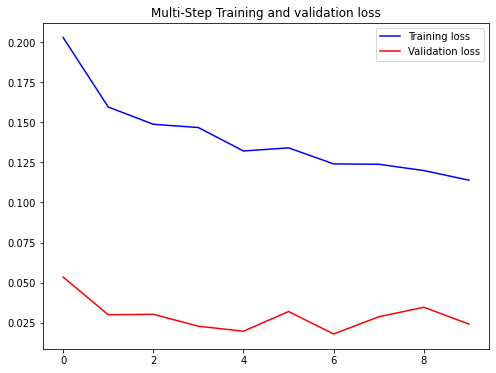

In [31]:
#图表示随着epoch次数 loss 的变化趋势
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()
plot_train_history(history, 'Multi-Step Training and validation loss')

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))
  
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/1, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/1, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In [0]:
#latest_10days = x_test[-10:]
#latest_10days_ture = y_test[-10:]
#latest_10days_predicted = []
#for data in latest_10days:
#  latest_10days_predicted.append( multi_step_model.predict(np.expand_dims(data,0)))

In [0]:
#latest_10days_predicted

In [0]:
def create_time_steps(length):
  return list(range(-length, 0))
  
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/1, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/1, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

(5, 5, 2)
(5, 2)
(5, 2)
(2,)


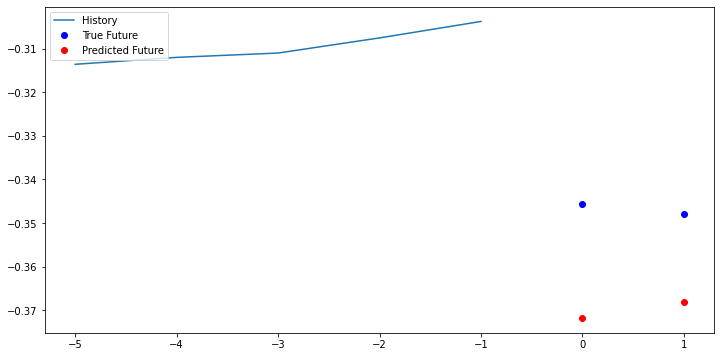

(5, 5, 2)
(5, 2)
(5, 2)
(2,)


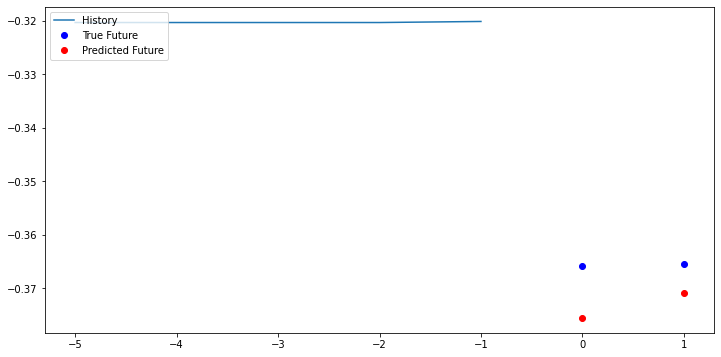

(5, 5, 2)
(5, 2)
(5, 2)
(2,)


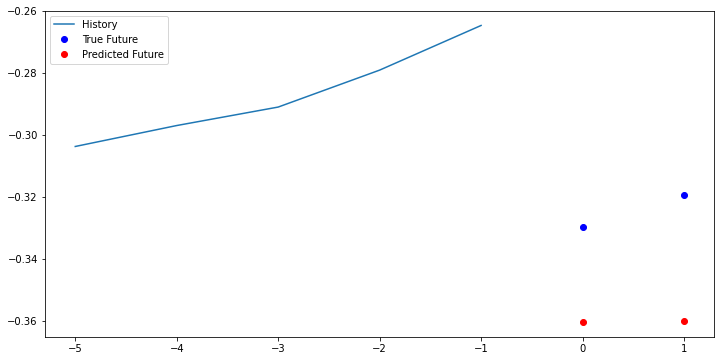

In [36]:
for x, y in test_data.take(3):
  print(x.shape)
  print(x[0].shape)
  print(y.shape)
  print(y[0].shape)
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [44]:
data = canada_data.values[-5:]
data = (data - data_mean) / data_std
data

array([[-0.16630925,  0.14439521],
       [-0.15857826,  0.21360728],
       [-0.10743479,  0.29989895],
       [-0.01823107,  0.4159806 ],
       [-0.03517978,  0.52640215]])

In [0]:
#num = (predict[0][0] * data_std) + data_mean
#num[0]

In [45]:
predicts = multi_step_model.predict(np.expand_dims(data,0))
future_5_days = []
for predict in predicts[0]:
  future_5_days.append(((predict * data_std) + data_mean)[0])
future_5_days

[1513.468194439751, 1489.4128098880115]